In [1]:
import requests
import json
import pandas as pd
import os
import shutil

In [2]:
import findspark
findspark.init("/opt/spark")
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import udf

In [3]:
sc = SparkContext(appName="Pokemon")
spark = SparkSession(sc)

# Get the list of all the Pokemon

In [4]:
def fetch_data(endpoint):
    print(f'fetching from {endpoint}')
    response_API = requests.get(endpoint)
    if response_API.status_code == 200:
        data = json.loads(response_API.text)
        return data
    raise f'no data fetched from {endpoint}'
    

    
pokemon_all = fetch_data('https://pokeapi.co/api/v2/pokemon?limit=100000&offset=0').get('results')
pokemon_all[0:5]

fetching from https://pokeapi.co/api/v2/pokemon?limit=100000&offset=0


[{'name': 'bulbasaur', 'url': 'https://pokeapi.co/api/v2/pokemon/1/'},
 {'name': 'ivysaur', 'url': 'https://pokeapi.co/api/v2/pokemon/2/'},
 {'name': 'venusaur', 'url': 'https://pokeapi.co/api/v2/pokemon/3/'},
 {'name': 'charmander', 'url': 'https://pokeapi.co/api/v2/pokemon/4/'},
 {'name': 'charmeleon', 'url': 'https://pokeapi.co/api/v2/pokemon/5/'}]

This only returns the pokemon names and urls, so their individual urls each have to be fetched to get more data on each one.

In [5]:
# do not run this, it's just a test: executed in 3 min 14 seconds
# all_data = [fetch_data(x.get('url')) for x in pokemon_all] 

# Fetching the full data & extracting the data
I want to use spark to do this because it will take much longer to make all the api calls without it, even though it's only 1154 pokemon. The test above took 3 min 14 seconds to make all those api calls without spark. 

In [6]:
pokemon_df = spark.createDataFrame(pokemon_all)

In [7]:
pokemon_df.rdd.count()

1154

The functions for filtering and parsing the data out of the json

In [8]:
color_set = set(('red', 'blue', 'leafgreen','white'))

def in_game_color(game_indices):
    '''
    Checks game_indices to see if the name of any of the games is in the color_set list

            Parameters:
                    game_indices (list): list of dicts of game indices

            Returns:
                    bool: True if list contains at any game in the color_set list, otherwise False
    '''
    if len(color_set.intersection(set([game['version']['name'] for game in game_indices]))) > 0:
        return True
    print(game_indices)
    return False

def get_typename(slot_num, type_list):
    '''
    Gets the name of the pokemon's type for a given slot number

            Parameters:
                    slot_num (int): number of slot requested
                    type_list (list): list of dicts of types and their slot
            Returns:
                    str: name of the type (or None if it doesn't exist)
    '''
    name = [x["type"]["name"] for x in type_list if x.get("slot") == slot_num]
    if len(name) > 0:
        return name[0]
    return None


First this makes the api calls on the rdd to get the data.
Then it answers the questions from the requirements
1. 
   - Filter out pokemon that do not appear in any of the games red, blue, leafgreen or white
   - get the id, base_experience, weight, and height and order
2. Get name of slot 1 and 2 of the pokemon's types
3. Calculate BMI
4. Capitalize first letter of the pokemon's name
5. Get the url of the front_default sprite

In [9]:
rdd2=(pokemon_df.rdd
      .map(lambda x: (x[0], fetch_data(x[1]))) # fetch each pokemon's data for each url from the api
      .filter(lambda x: in_game_color(x[1].get("game_indices"))) # 1. filter out pokemon that don't appear in red, blue, leafgreen or white games
      .map(lambda x: (x[0].title(), # 4. the pokemon name, first letter capitalized
                      x[1].get('id'), # 1b
                      x[1].get('base_experience'), # 1
                      x[1].get('weight'), # 1
                      x[1].get('height'), # 1
                      x[1].get('order'), # 1
                      get_typename(1, x[1].get('types')), # 2
                      get_typename(2, x[1].get('types')), # 2
                      x[1].get('sprites').get('front_default'), # 5
                     ))
     )

poke_df = rdd2.toDF(["name","id","base_experience","weight","height","order","type_primary","type_secondary","front_default_sprite_url"])
poke_df = poke_df.withColumn('bmi', poke_df.weight / poke_df.height**2) # 3. calculate bmi
poke_df.show()

+----------+---+---------------+------+------+-----+------------+--------------+------------------------+------------------+
|      name| id|base_experience|weight|height|order|type_primary|type_secondary|front_default_sprite_url|               bmi|
+----------+---+---------------+------+------+-----+------------+--------------+------------------------+------------------+
| Bulbasaur|  1|             64|    69|     7|    1|       grass|        poison|    https://raw.githu...|1.4081632653061225|
|   Ivysaur|  2|            142|   130|    10|    2|       grass|        poison|    https://raw.githu...|               1.3|
|  Venusaur|  3|            263|  1000|    20|    3|       grass|        poison|    https://raw.githu...|               2.5|
|Charmander|  4|             62|    85|     6|    5|        fire|          null|    https://raw.githu...| 2.361111111111111|
|Charmeleon|  5|            142|   190|    11|    6|        fire|          null|    https://raw.githu...|1.5702479338842976|


Fetching the urls and parsing all the data only took 20 seconds with spark!

# Print out the data to single csv
The file is not large enough to warrant writing it out to multiple files (only 667 rows), so I wrote it out to one.

In [10]:
out_dir = os.getcwd() + os.sep + 'pokemon_out_csv'
out_dir
# check if out directory already exists and remove it if so
if os.path.exists(out_dir) and os.path.isdir(out_dir):
    shutil.rmtree(out_dir)
    print(f'old {out_dir} removed')

old /Users/sallyisa/git/pokemon-project/pokemon_out_csv removed


In [11]:
poke_df.coalesce(1).write.options(header='True', delimiter=',', quote='"').csv(out_dir +'/')

In [12]:
# stop the spark context
sc.stop()

# Bonus
1. Imagine the Pokémon are subject to the GDPR. How would you pseudonymize the data to no longer make it re-identifiable?

    In case the order and id are indicative of some sort of order of pokemon appearance that may be known, I would change the order and id using a Counter. The names are obviously identifiers, so they could be encrypted. See [this post](https://blog.isc2.org/isc2_blog/2021/06/best-practices-and-techniques-for-pseudonymization.html) for techniques.
    

2. Imagine you had to build a system in the cloud that would continiously deliver updates to the investor with updates about Pokémon. Draw an architecture for exposing new changes to the existing Pokémon to the investor.

    *I used [this AWS blog post](https://aws.amazon.com/blogs/database/dynamodb-streams-use-cases-and-design-patterns/) for inspiration.*
    - Let's assume the pokemon data is stored in one or more DynamoDB tables. 
    - Define an SNS topic and subscribers (email or SMS).
    - Write a Lambda to read the DynamoDB stream (perhaps filtering them) and publish a message to the SNS topic. 
    - Investors (who are subscribed to the SNS topic) receive pokemon update notifications in near real-time        fashion and can take appropriate action.

 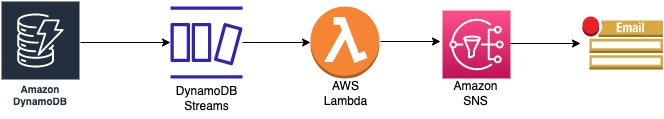



3. Make a interactable dashboard using the data where users can get a detailed page about the Pokémon, including showing the image from the url of the sprite.

     *See my streamlit app!*
     
     To run the dashboard locally: 
     
    - install streamlit
    ```>> pip install streamlit```
    - run the app
    ```>> streamlit run pokemon_streamlit_app.py```
    
    

4. If a spark compatible framework was not already chosen for the primary requirements, consider how the code would change to be executed on a spark engine.

    *I executed it in pyspark locally :) If it were a larger dataset, I would consider running this in Glue.*